In [13]:
import sys
sys.path.append('../')

import torch
import torchvision.transforms as transforms
from PIL import Image
import os

import mmgclip

In [2]:
model_path = '../mmgclip/models/image_encoders/clf_convnext_tiny/classifier_convnext_tiny_16bits_images.pt'

Loading the image encoder network.

In [3]:
image_encoder = torch.jit.load(model_path)
image_encoder.eval()
print(image_encoder)

RecursiveScriptModule(
  original_name=ConvNeXt_spm
  (features): RecursiveScriptModule(
    original_name=Sequential
    (0): RecursiveScriptModule(
      original_name=Conv2dNormActivation
      (0): RecursiveScriptModule(original_name=Conv2d)
      (1): RecursiveScriptModule(original_name=LayerNorm2d)
    )
    (1): RecursiveScriptModule(
      original_name=Sequential
      (0): RecursiveScriptModule(
        original_name=CNBlock
        (block): RecursiveScriptModule(
          original_name=Sequential
          (0): RecursiveScriptModule(original_name=Conv2d)
          (1): RecursiveScriptModule(original_name=Permute)
          (2): RecursiveScriptModule(original_name=LayerNorm)
          (3): RecursiveScriptModule(original_name=Linear)
          (4): RecursiveScriptModule(original_name=GELU)
          (5): RecursiveScriptModule(original_name=Linear)
          (6): RecursiveScriptModule(original_name=Permute)
        )
        (stochastic_depth): RecursiveScriptModule(original_n

In [4]:
softmax = torch.nn.Softmax(dim=1)
transform = transforms.Compose([transforms.ToTensor()])

Loading a sample dataset.

In [5]:
dataset = mmgclip.create_dataset_df(
    os.path.join(os.getcwd(), '../data/02_data_T_regions'))

dataset.head()

,file_name,type,mass_margin,mass_shape,image_path
0,p0200343901mr,1,[-1],[-1],/storage/Features/features/png_archive/2D_100m...
1,p0200360201mr,1,"[-1, -1, -1, -1, -1, -1]","[-1, -1, -1, -1, -1, -1]",/storage/Features/features/png_archive/2D_100m...
2,p0200311601ml,1,"[-1, -1, -1, -1]","[-1, -1, -1, -1]",/storage/Features/features/png_archive/2D_100m...
3,p0200322801cl,1,[-1],[-1],/storage/Features/features/png_archive/2D_100m...
4,p0200385403cl,1,"[-1, -1]","[-1, -1]",/storage/Features/features/png_archive/2D_100m...


In [6]:
sample_view = dataset.iloc[:1]
sample_view

,file_name,type,mass_margin,mass_shape,image_path
0,p0200343901mr,1,[-1],[-1],/storage/Features/features/png_archive/2D_100m...


In [7]:
sample_image_path = sample_view['image_path'][0]
sample_image_path

'/storage/Features/features/png_archive/2D_100micron/0/02/02003439/st01/p0200343901mr.png'

subject: p0200343901mr
size: (818, 1906)
data range: (0, 255)


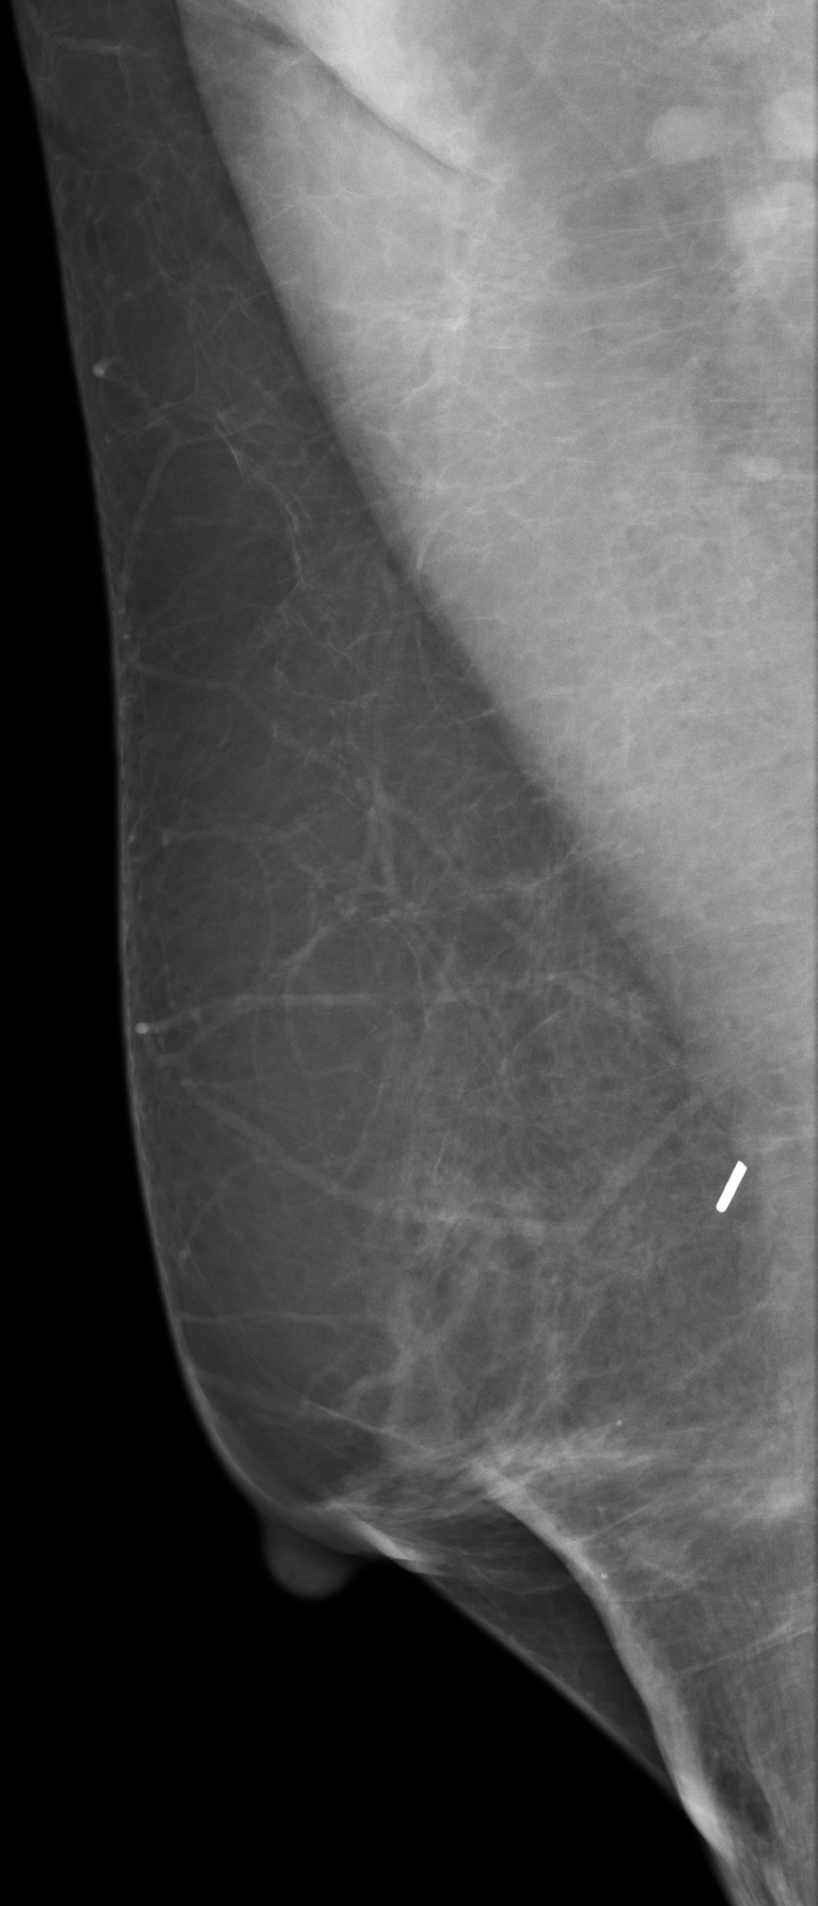

In [8]:
img_whole = Image.open(
    sample_image_path
)

print(f"subject: {sample_view['file_name'][0]}")
print(f"size: {img_whole.size}")
print(f"data range: {img_whole.getextrema()}")

display(img_whole)

Applying transformation

In [9]:
tensor = transform(img_whole)
tensor

tensor([[[0.0000, 0.0000, 0.0000,  ..., 0.6235, 0.5922, 0.5647],
         [0.0000, 0.0000, 0.0000,  ..., 0.6078, 0.5765, 0.5529],
         [0.0000, 0.0000, 0.0000,  ..., 0.6000, 0.5882, 0.5569],
         ...,
         [0.0000, 0.0000, 0.0000,  ..., 0.3569, 0.3176, 0.2941],
         [0.0000, 0.0000, 0.0000,  ..., 0.3569, 0.3294, 0.3176],
         [0.0000, 0.0000, 0.0000,  ..., 0.3490, 0.3333, 0.3216]]])

In [10]:
# Dicom images in 16bits, while pngs are 8 bits to save space
tensor = 65535 * tensor
tensor = tensor.unsqueeze(0)
print(tensor.shape, tensor.min(), tensor.max())

torch.Size([1, 1, 1906, 818]) tensor(0.) tensor(65535.)


In [11]:
# Forward pass whole network in one go to get posterior
# You can apply some temperature to avoid very spiky distribution at the edges
print(f"image_encoder(tensor): {image_encoder(tensor)}")
print(f"Direct output: {softmax(image_encoder(tensor) / 2)}")

image_encoder(tensor): tensor([[ 3.5080, -4.0372]], grad_fn=<AddmmBackward0>)
Direct output: tensor([[0.9775, 0.0225]], grad_fn=<SoftmaxBackward0>)


In [19]:
# Apply Forward pass in stages
tensor_norm = (tensor - 32767.5) / 32767.5

feature_map = image_encoder.features((tensor_norm))
print(feature_map.shape)

features = image_encoder.avgpool(feature_map)
print(features.shape)

logits = image_encoder.classifier(features)
print("logits: ", logits, logits.shape)

# Output should be the same as applying the network directly
posteriors = softmax(logits / 2)
print(posteriors, posteriors.shape)
print("Posterior for malignant class:", posteriors[0, 1])

torch.Size([1, 768, 59, 25])
torch.Size([1, 768, 1, 1])
logits:  tensor([[ 3.5081, -4.0373]], grad_fn=<AddmmBackward0>) torch.Size([1, 2])
tensor([[0.9775, 0.0225]], grad_fn=<SoftmaxBackward0>) torch.Size([1, 2])
Posterior for malignant class: tensor(0.0225, grad_fn=<SelectBackward0>)
